In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import pickle
from pathlib import Path
from ngboost import NGBRegressor
from sklearn.tree import DecisionTreeRegressor
from scipy.integrate import quad
import seaborn as sns
import scipy

def get_preproc_ngboost(path, split_date='2022-04-27 00:00:00'):
    '''removed columns for ngboost, returns X and y train and test set.
    similar to sklearn train test split. Format needs to be ADV_OHE_TEAM_ALL'''
    df = pd.read_pickle(path)
    df.set_index('GAME_ID', inplace=True)

    train_test_split_date = split_date
    X_train = df.loc[df.GAME_DATE < train_test_split_date, ~df.columns.isin(['PLUS_MINUS'])]
    X_test = df.loc[df.GAME_DATE > train_test_split_date, ~df.columns.isin(['PLUS_MINUS'])]
    y_train = df.loc[df.GAME_DATE < train_test_split_date, ['PLUS_MINUS']]['PLUS_MINUS']
    y_test = df.loc[df.GAME_DATE > train_test_split_date, ['PLUS_MINUS']]['PLUS_MINUS']
    
    columns_keep = ['OFF_RATING_Roll_mean_h', 'DEF_RATING_Roll_mean_h',
       'NET_RATING_Roll_mean_h', 'OREB_PCT_Roll_mean_h', 'EFG_PCT_Roll_mean_h',
       'TS_PCT_Roll_mean_h', 'NET_RATING_Roll_median_h',
       'NET_RATING_Roll_std_h', 'AST_PCT_Roll_std_h', 'AST_TOV_Roll_std_h',
       'PACE_Roll_std_h', 'DEF_RATING_Roll_mean_a', 'NET_RATING_Roll_mean_a',
       'AST_TOV_Roll_mean_a', 'TM_TOV_PCT_Roll_mean_a',
       'NET_RATING_Roll_median_a', 'AST_TOV_Roll_median_a',
       'DREB_PCT_Roll_median_a', 'TS_PCT_Roll_median_a',
       'DEF_RATING_Roll_std_a', 'AST_TOV_Roll_std_a', 'ATL_h', 'BKN_h',
       'BOS_h', 'CHA_h', 'CHI_h', 'CLE_h', 'DAL_h', 'DEN_h', 'DET_h', 'GSW_h',
       'HOU_h', 'IND_h', 'LAC_h', 'LAL_h', 'MEM_h', 'MIA_h', 'MIL_h', 'MIN_h',
       'NOP_h', 'NYK_h', 'OKC_h', 'ORL_h', 'PHI_h', 'PHX_h', 'POR_h', 'SAC_h',
       'SAS_h', 'TOR_h', 'UTA_h', 'WAS_h', 'ATL_a', 'BKN_a', 'BOS_a', 'CHA_a',
       'CHI_a', 'CLE_a', 'DAL_a', 'DEN_a', 'DET_a', 'GSW_a', 'HOU_a', 'IND_a',
       'LAC_a', 'LAL_a', 'MEM_a', 'MIA_a', 'MIL_a', 'MIN_a', 'NOP_a', 'NYK_a',
       'OKC_a', 'ORL_a', 'PHI_a', 'PHX_a', 'POR_a', 'SAC_a', 'SAS_a', 'TOR_a',
       'UTA_a', 'WAS_a']

    X_train = X_train[columns_keep]
    X_test = X_test[columns_keep]

    return (X_train, X_test, y_train, y_test)

def get_new_preproc_ngboost(path):
    df = pd.read_pickle(path)
    df.set_index('GAME_ID', inplace=True)
    
    columns_keep = ['OFF_RATING_Roll_mean_h', 'DEF_RATING_Roll_mean_h',
       'NET_RATING_Roll_mean_h', 'OREB_PCT_Roll_mean_h', 'EFG_PCT_Roll_mean_h',
       'TS_PCT_Roll_mean_h', 'NET_RATING_Roll_median_h',
       'NET_RATING_Roll_std_h', 'AST_PCT_Roll_std_h', 'AST_TOV_Roll_std_h',
       'PACE_Roll_std_h', 'DEF_RATING_Roll_mean_a', 'NET_RATING_Roll_mean_a',
       'AST_TOV_Roll_mean_a', 'TM_TOV_PCT_Roll_mean_a',
       'NET_RATING_Roll_median_a', 'AST_TOV_Roll_median_a',
       'DREB_PCT_Roll_median_a', 'TS_PCT_Roll_median_a',
       'DEF_RATING_Roll_std_a', 'AST_TOV_Roll_std_a', 'ATL_h', 'BKN_h',
       'BOS_h', 'CHA_h', 'CHI_h', 'CLE_h', 'DAL_h', 'DEN_h', 'DET_h', 'GSW_h',
       'HOU_h', 'IND_h', 'LAC_h', 'LAL_h', 'MEM_h', 'MIA_h', 'MIL_h', 'MIN_h',
       'NOP_h', 'NYK_h', 'OKC_h', 'ORL_h', 'PHI_h', 'PHX_h', 'POR_h', 'SAC_h',
       'SAS_h', 'TOR_h', 'UTA_h', 'WAS_h', 'ATL_a', 'BKN_a', 'BOS_a', 'CHA_a',
       'CHI_a', 'CLE_a', 'DAL_a', 'DEN_a', 'DET_a', 'GSW_a', 'HOU_a', 'IND_a',
       'LAC_a', 'LAL_a', 'MEM_a', 'MIA_a', 'MIL_a', 'MIN_a', 'NOP_a', 'NYK_a',
       'OKC_a', 'ORL_a', 'PHI_a', 'PHX_a', 'POR_a', 'SAC_a', 'SAS_a', 'TOR_a',
       'UTA_a', 'WAS_a']
    X = df[columns_keep]

    return X

def update_ngboost(X_train, y_train, file_path):
    '''return the newly update ngboost model
    save the new model as the pickle file'''

    base=DecisionTreeRegressor(criterion='friedman_mse', max_depth=5)
    ngb = NGBRegressor(col_sample=0.4, minibatch_frac=0.2,
                 n_estimators=485, Base=base, learning_rate=0.01)
    y_train = y_train.ravel()
    weights_loc = np.argwhere((y_train < -15) | (y_train > 15))
    sample_weight = np.array([1] * y_train.shape[0])
    sample_weight[weights_loc.ravel()] += 1
    for i in range(5):
        ngb.fit(X_train.reset_index(drop=True), y_train, sample_weight=sample_weight)
    with file_path.open("wb") as f:
        pickle.dump(ngb, f)

def load_ngboost_team_model(file_path):
    '''use path.home to reach data/pkl folder, this returns the
    model from the pkl file'''
    with file_path.open("rb") as f:
        ngb_unpickled = pickle.load(f)
    return ngb_unpickled

def visualise_distribution(model, X_test, game_index:int):
    '''accepts the ng boost model, and the distribution of predicted values. Specify the game_index for one distribution. X_test can be you split model or the new data you want to predict'''
    Y_dist = model.pred_dist(X_test)
    value = np.random.normal(loc=Y_dist.params['loc'][game_index],
                             scale=Y_dist.params['scale'][game_index],size=1000)
    sns.histplot(value, kde=True)

def get_mean_std_normal_distribution(model, X_test):
    '''returns the normal distribution mean and standard deviation of games by their index
    from the Y_dist params loc and scale respectively given the NGboost model.
    '''
    Y_dist = model.pred_dist(X_test)

    mean = Y_dist.params['loc']
    std = Y_dist.params['scale']

    return (mean, std)

def normal_distribution_function(x, mean, std):
    '''returns the point probability of the normal distribution of a given PLUS_MINUS'''
    value = scipy.stats.norm.pdf(x,loc=mean,scale=std)
    return value

def single_range_distribution_prediction(mean, std, x1=0,x2=100):
    '''returns the probability over the range of values.
    defaults to the right side of the distribution'''
    return quad(normal_distribution_function, x1, x2, args=(mean, std))

def get_left_betting_metric(x_min, x_max, mean, std, percentile=0.54):
    '''gets_the_cumulative_sum of PLUS_MINUS probability until the Nth percentile distribution
    (cumulative sum from the left side)'''
    x = np.linspace(x_min, x_max, 1000)
    cum_sum = scipy.stats.norm.cdf(x, mean, std)
    bet_left = np.argwhere(np.isclose(cum_sum, percentile, rtol=1e-02, atol=1e-04))[0][0]
    return np.round(x[bet_left], 2)

def get_right_betting_metric(x_min, x_max, mean, std, percentile=0.54):
    '''gets_the_cumulative_sum of PLUS_MINUS probability until the Nth percentile
    (cumulative sum from the right side)'''
    x = np.linspace(x_min, x_max, 1000)
    cum_sum = scipy.stats.norm.cdf(x, mean, std)
    bet_right = np.argwhere(np.isclose(1-cum_sum, percentile, rtol=1e-02, atol=1e-04))[0][0]
    return np.round(x[bet_right], 2)

def get_betting_prediction(model, X_test, betting_plus_minus):
    '''returns the probability of the PLUS_MINUS on multiple games.
    defaults to the right side of the distribution. Over large data and
    returns a list. X_test can be the new data, y_test can also be the sbr's
    actual metrics'''
    dist_prob = []
    means, stdevs = get_mean_std_normal_distribution(model, X_test)
    y_temp = betting_plus_minus.reset_index(drop=True)
    #loops over different games
    for i in range(y_temp.shape[0]):
        mean = means[i]
        std = stdevs[i]
        if y_temp[i] >= 0:
            dist_prob.append(quad(normal_distribution_function, y_temp[i], 110, args=(mean, std))[0])
        elif y_temp[i] < 0:
            dist_prob.append(quad(normal_distribution_function, -110, y_temp[i], args=(mean, std))[0])
    return pd.DataFrame({'betting_point_spread':betting_plus_minus, 'model_odds': np.round(dist_prob,2)}, index=X_test.index)

#The main y_pred that we want to do
#---------------------------------------------------------------------------------------------------------------------------------------
def get_y_pred_percentile(file_path_df, file_path_model, new_df=False, percentile=0.54):
    '''get the y_pred in a neat package'''
    left_cumsums = []
    right_cumsums = []
    if new_df == True:
        X_test = get_new_preproc_ngboost(file_path_df)
        x_min =-110
        x_max =110
    elif new_df == False:
        X, X_test, y, y_test = get_preproc_ngboost(path, split_date='2022-04-27 00:00:00')
        x_min =min(y_test)
        x_max =max(y_test)
    model = load_ngboost_team_model(file_path)
    mean, std = get_mean_std_normal_distribution(model, X_test)
    for i in range(X_test.shape[0]):
        left_cumsums.append(get_left_betting_metric(x_min, x_max, mean[i], std[i], percentile))
        right_cumsums.append(get_right_betting_metric(x_min, x_max, mean[i], std[i], percentile))
    return pd.DataFrame({f'left_{percentile}':left_cumsums, f'right_{percentile}': right_cumsums}, index=X_test.index)


-7.85

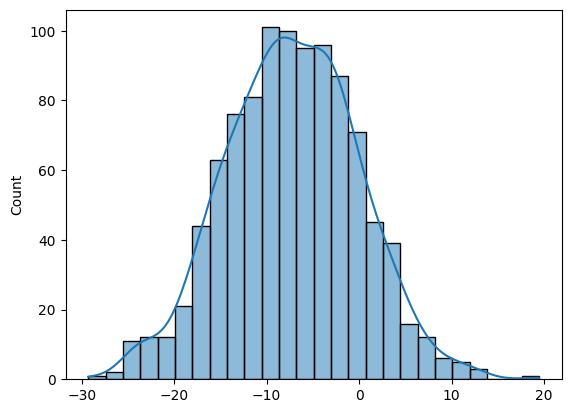

In [39]:
if __name__ == "__main__":
    #GET THE MAIN BETTING ODDS
    file_path_df = '../data/pkl/ADV_OHE_TEAM_ALL'
    file_path_model = Path.home()/'code'/'alecmatt5'/'nba_betting_analysis'/'backend'/'data'/'pkl'/'ngdemo.pkl'
    get_y_pred_percentile(file_path_df, file_path_model, new_df=False, percentile=0.54)


#     #=------------------------------------------TEST THE FUNCTIONS--------------------------------------------------
#     path = '../data/pkl/ADV_OHE_TEAM_ALL'
#     #get data
#     X_train, X_test, y_train, y_test = get_preproc_ngboost(path, split_date='2022-04-27 00:00:00')

#     #load model as unpickle ngboost
#     file_path = Path.home()/'code'/'alecmatt5'/'nba_betting_analysis'/'backend'/'data'/'pkl'/'ngdemo.pkl'
#     unpickle_ngb = load_ngboost_team_model(file_path)

#     #visualise distributions of PLUS_MINUS of each game, modify the interger
#     #at the third param of visualise_distribution
#     visualise_distribution(unpickle_ngb, X_test, 0)

#     #get arrays of mean and std of different games specified at X_test
#     mean, std = get_mean_std_normal_distribution(unpickle_ngb, X_test)

#     #get the probability at a single point
#     normal_distribution_function(5, mean[0], std[0])

#     #get the probability of the range of values
#     single_range_distribution_prediction(mean[0], std[0], x1=0,x2=max(y_test))

#     #get the probability of the range of values based on the cumulative percentile
#     #cum_sum from the left side
#     get_left_betting_metric(min(y_test), max(y_test), mean[0], std[0], percentile=0.54)
#     #get the probability of the range of values based on the cumulative percentile
#     #cum_sum from the right side
#     get_right_betting_metric(min(y_test), max(y_test), mean[0], std[0], percentile=0.54)

#     #get all range of probability distribution of a given betting odds, the betting odds being the y_test
#     dist_prob = get_betting_prediction(unpickle_ngb, X_test, y_test)

In [8]:
X_train.columns

Index(['OFF_RATING_Roll_mean_h', 'DEF_RATING_Roll_mean_h',
       'NET_RATING_Roll_mean_h', 'OREB_PCT_Roll_mean_h', 'EFG_PCT_Roll_mean_h',
       'TS_PCT_Roll_mean_h', 'NET_RATING_Roll_median_h',
       'NET_RATING_Roll_std_h', 'AST_PCT_Roll_std_h', 'AST_TOV_Roll_std_h',
       'PACE_Roll_std_h', 'DEF_RATING_Roll_mean_a', 'NET_RATING_Roll_mean_a',
       'AST_TOV_Roll_mean_a', 'TM_TOV_PCT_Roll_mean_a',
       'NET_RATING_Roll_median_a', 'AST_TOV_Roll_median_a',
       'DREB_PCT_Roll_median_a', 'TS_PCT_Roll_median_a',
       'DEF_RATING_Roll_std_a', 'AST_TOV_Roll_std_a', 'ATL_h', 'BKN_h',
       'BOS_h', 'CHA_h', 'CHI_h', 'CLE_h', 'DAL_h', 'DEN_h', 'DET_h', 'GSW_h',
       'HOU_h', 'IND_h', 'LAC_h', 'LAL_h', 'MEM_h', 'MIA_h', 'MIL_h', 'MIN_h',
       'NOP_h', 'NYK_h', 'OKC_h', 'ORL_h', 'PHI_h', 'PHX_h', 'POR_h', 'SAC_h',
       'SAS_h', 'TOR_h', 'UTA_h', 'WAS_h', 'ATL_a', 'BKN_a', 'BOS_a', 'CHA_a',
       'CHI_a', 'CLE_a', 'DAL_a', 'DEN_a', 'DET_a', 'GSW_a', 'HOU_a', 'IND_a',
       'LA

In [10]:
0 == True

False

In [13]:
X_test.shape

(1121, 81)

In [20]:
X_test.shape

(1121, 81)

In [27]:
X_test.reset_index()

,GAME_ID,OFF_RATING_Roll_mean_h,DEF_RATING_Roll_mean_h,NET_RATING_Roll_mean_h,OREB_PCT_Roll_mean_h,EFG_PCT_Roll_mean_h,TS_PCT_Roll_mean_h,NET_RATING_Roll_median_h,NET_RATING_Roll_std_h,AST_PCT_Roll_std_h,...,OKC_a,ORL_a,PHI_a,PHX_a,POR_a,SAC_a,SAS_a,TOR_a,UTA_a,WAS_a
0,22200973,111.54,116.14,-4.60,0.3026,0.5592,0.5916,-7.1,13.970326,0.127878,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,22200970,111.78,120.28,-8.50,0.2124,0.5608,0.6034,-5.7,8.601453,0.058127,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,22200969,115.54,117.96,-2.38,0.2658,0.5676,0.5962,4.3,9.970306,0.084728,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,22200968,116.70,117.66,-0.98,0.2800,0.5404,0.5696,-6.1,15.917192,0.036414,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,22200967,112.02,124.22,-12.24,0.3424,0.5094,0.5368,-18.0,14.498724,0.088240,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1116,42100231,113.32,106.82,6.48,0.3060,0.5332,0.5756,8.0,14.657319,0.051936,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1117,42100211,121.88,115.34,6.52,0.3312,0.5868,0.6214,4.2,12.226079,0.053268,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1118,42100156,108.92,114.60,-5.66,0.2510,0.5352,0.5852,-3.9,14.665708,0.065028,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1119,42100176,109.20,116.32,-7.12,0.2710,0.5000,0.5540,-6.7,13.271662,0.055430,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
